In [26]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, matplotlib.ticker as ticker
import seaborn as sns
import datetime
import warnings

sns.set(style='darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')

In [5]:
spy = pd.read_csv('data/SPY.csv', parse_dates=True, index_col=0)
adj_ratio = spy['Adj Close']/spy['Close']
cols = ['Open', 'High', 'Low', 'Close']
spy[cols] = spy[cols].multiply(adj_ratio, axis=0)
spy.drop('Adj Close', axis='columns', inplace=True)

In [52]:
def sharpe_ratio(x, periods=252):
    mean = np.mean(x)
    std = np.std(x)
    if std > 0:
        return mean / std * np.sqrt(periods)
    else:
        return mean
    
def returns_summary(returns):
    summary = pd.Series()
    summary['# returns'] = returns.count()
    summary['mean return %'] = np.round(returns.mean() * 100, 2)
    summary['mean abs return %'] = np.round(returns.abs().mean() * 100, 2)
    summary['return std %'] = np.round(returns.std() * 100, 2)
    summary['sharpe ratio'] = np.round(sharpe_ratio(returns), 2)
    summary['# gains'] = returns[returns > 0].count()
    summary['# losses'] = returns[returns <= 0].count()
    summary['win %'] = np.round(returns[returns >0].count() / returns.count() * 100, 2)
    summary['mean gain %'] = np.round(returns[returns>0].mean() * 100, 2)
    summary['mean loss %'] = np.round(returns[returns <= 0].mean() * 100, 2)
    summary['win/loss'] = np.round(summary['mean gain %'] / abs(summary['mean loss %']), 2)
    return summary

def ohlc_barchart(ax, ohlc_df):
    opens = ohlc_df['Open']
    highs = ohlc_df['High']
    lows = ohlc_df['Low']
    closes = ohlc_df['Close']
    bar_heights = highs - lows

    bars = ax.bar(bar_heights.index, bar_heights, bottom=lows, width=0.1, color='k')

    # Make most of the ticklabels empty so the labels don't get too crowded
    # ticklabels = ['']*len(bar_heights.index)
    # Every 4th ticklable shows the month and day
    ticklabels = [item.strftime('%b %d') for item in bar_heights.index]
    # Every 12th ticklabel includes the year
    # ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in bar_heights.index[::12]]
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()

    for opening, closing, bar in zip(opens, closes, bars):
        x, w = bar.get_x(), 0.2

        ax.plot((x - w, x), (opening, opening), color='k')
        ax.plot((x, x + w), (closing, closing), color='k')

def swing_high(ohlc_df):
    swing_highs = pd.Series(index=ohlc_df.index)
    # Initialize highs and lows on first bar
    first_idx = ohlc_df.index[0]
    bar_high = prev_bar_high = ohlc_df.loc[first_idx, 'High']
    bar_low = prev_bar_low = ohlc_df.loc[first_idx, 'Low']
    for idx in ohlc_df.index[1:]:
        bar = ohlc_df.loc[idx]
        if bar['High'] > prev_bar_high:
            bar_high = bar['High']
            bar_low = bar['Low']
            # bar_idx = idx
        elif (bar['High'] < bar_high) & (bar['Low'] < bar_low):
            swing_high = bar_high
            swing_highs.loc[idx] = swing_high
        # skip inside bars
        elif (bar['High'] < prev_bar_high) & (bar['Low'] > prev_bar_low):
            continue
        prev_bar_high = bar['High']
        prev_bar_low = bar['Low']
    return swing_highs

def swing_low(ohlc_df):
    swing_lows = pd.Series(index=ohlc_df.index)
    # Initialize highs and lows on first bar
    first_idx = ohlc_df.index[0]
    bar_high = prev_bar_high = ohlc_df.loc[first_idx, 'High']
    bar_low = prev_bar_low = ohlc_df.loc[first_idx, 'Low']
    for idx in ohlc_df.index[1:]:
        bar = ohlc_df.loc[idx]
        if bar['Low'] < prev_bar_low:
            bar_high = bar['High']
            bar_low = bar['Low']
            # bar_idx = idx
        elif (bar['High'] > bar_high) & (bar['Low'] > bar_low):
            swing_low = bar_low
            swing_lows.loc[idx] = swing_low
        # skip inside bars
        elif (bar['High'] < prev_bar_high) & (bar['Low'] > prev_bar_low):
            continue
        prev_bar_high = bar['High']
        prev_bar_low = bar['Low']
    return swing_lows

In [14]:
spy['swing highs'] = swing_high(spy)
spy['swing lows'] = swing_low(spy)

state = None
for date in spy.index[1:]:
    # yesterday = date - datetime.timedelta(days=1)
    if not np.isnan(spy.loc[date, 'swing highs']):
        state = 'swing high more recent'
    elif not np.isnan(spy.loc[date, 'swing lows']):
        state = 'swing low more recent'
    spy.loc[date, 'recent swing'] = state

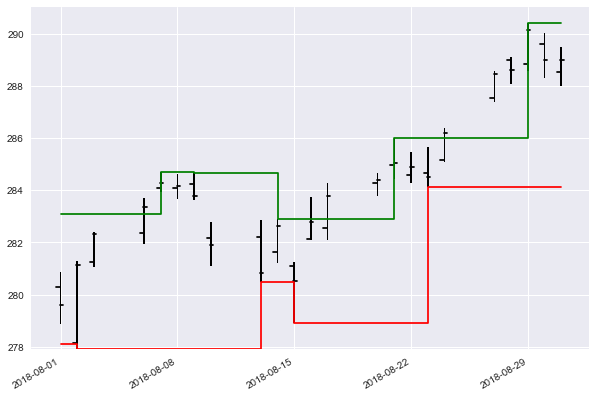

In [50]:
start_date = '8/1/2018'
end_date = '9/1/2018'

fig, ax = plt.subplots(figsize=(10, 7))
dates = pd.date_range(start_date, end_date, freq='B')
ohlc_barchart(ax, spy.loc[dates])
spy['swing highs'].ffill().loc[dates].plot(ax=ax, linestyle='steps', color='g')
spy['swing lows'].ffill().loc[dates].plot(ax=ax, linestyle='steps', color='r')

# low_more_recent_idx = spy[spy['recent swing']=='swing low more recent'].index
# high_more_recent_idx = spy[spy['recent swing']=='swing high more recent'].index
# for idx in low_more_recent_idx.intersection(dates):
#     ax.axvspan(idx, idx+datetime.timedelta(days=1), facecolor='g', alpha=0.1)
# for idx in high_more_recent_idx.intersection(dates):
#     ax.axvspan(idx, idx+datetime.timedelta(days=1), facecolor='r', alpha=0.1)
    
# print('green == swing low more recent == downtrend started')
# print('red == swing high more recent == uptrend started')

In [53]:
spy['returns'] = spy['Open'].pct_change().shift(-2)
spy.groupby('recent swing')['returns'].apply(returns_summary).unstack()

,# returns,mean return %,mean abs return %,return std %,sharpe ratio,# gains,# losses,win %,mean gain %,mean loss %,win/loss
recent swing,,,,,,,,,,,
swing high more recent,2867.0,0.08,0.90,1.33,1.01,1586.0,1281.0,55.32,0.89,-0.91,0.98
swing low more recent,3600.0,0.01,0.69,0.99,0.17,1921.0,1679.0,53.36,0.65,-0.72,0.90
